# Functional MRI Network Analysis using Jupyter Notebooks and Python3 on brainlife.io

This example notebook will guide the user through grabbing data for their project from the secondary warehouse, compiling data across the entire project, and analyzing and visualizing the compiled results on brainlife.io via the 'Analysis' tab. This example is written for python3, and uses one of the Python3 notebook types.

Within this notebook, I will guide the user through analyses comprising derivatives generated from one of the three main datatypes available on brainlife.io, specifically neuro/func. Specifically, I will guide the user through:
        
    1. Load sample data for local network statistics.
    2. doing some simple data manipulations
    3. generating simple visualizations
    
All of these functions used here are provided in a self-contained python package called "pybrainlife" [https://pypi.org/project/pybrainlife/].

First thing we'll do is load our python modules, specifically pandas, and pybrainlife!

In [1]:
import warnings
warnings.filterwarnings('ignore')

### Import pandas and pybrainlife modules

In [2]:
import os,sys
import pandas as pd
import pybrainlife as pbl
from pybrainlife.data.collect import collect_data
from pybrainlife.data.collect import collect_subject_data
import pybrainlife.data.manipulate as pybldm
import pybrainlife.vis.plots as pyblvp
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import numpy as np
import random
from scipy.stats import ttest_ind

Next thing we'll do is we'll define some useful functions. Specifically, we will define a few fuctions to peform bootstrapping analyses on the data and plotting the histograms

### Define some useful functions for this notebook

In [3]:
# performs a bootstrapping analysis comparing data from two different groups
def bootstrap_analysis_groups(df,group_1,group_2,measures,iterations=1000,sample_size=10,compare_measure='corr'):

    compare = 'corr'
    if compare_measure == 'ttest':
        compare = 'p-value'
        
    correlation = {}
    for meas in measures:
        correlation[meas] = []
        for i in range(0,iterations):
            group_1_df = df.loc[df['classID'] == group_1].sample(sample_size).reset_index(drop=True)
            group_2_df = df.loc[df['classID'] == group_2].sample(sample_size).reset_index(drop=True)

            if compare_measure == 'ttest':
                corr = ttest_ind(group_1_df[meas], group_2_df[meas],equal_var=False)[1]
            else:
                corr = np.corrcoef(group_1_df[meas].values.tolist(),group_2_df[meas].values.tolist())[0][1]
            correlation[meas].append(corr)

    corrs = pd.DataFrame()

    for meas in measures:
        corrs[meas+'_'+compare] = correlation[meas]
    corrs['iterations'] = [ f+1 for f in range(iterations) ]
    
    return corrs[['iterations']+[ f for f in corrs.keys().tolist() if f != 'iterations'] ]

# performs a bootstrapping analysis within two individual groups comparing between different measures
def bootstrap_analysis_within_groups(df,group_1,group_2,measures,iterations=1000,sample_size=10,compare_measure='corr'):

    compare = 'corr'
    if compare_measure == 'ttest':
        compare = 'p-value'

    group_1_corrs = {}
    group_2_corrs = {}
    for meas in range(len(measures)):
        for meas_2 in range(len(measures)):
            if measures[meas] != measures[meas_2]:
                measures_name = measures[meas]+'_'+measures[meas_2]
                inv_measures_name = measures[meas_2]+'_'+measures[meas]
                if measures_name not in list(group_1_corrs.keys()):
                    if inv_measures_name not in list(group_1_corrs.keys()):
                        group_1_corrs[measures_name] = []
                        group_2_corrs[measures_name] = []
                        for i in range(0,iterations):
                            group_1_df = df.loc[df['classID'] == group_1].sample(sample_size).reset_index(drop=True)
                            group_2_df = df.loc[df['classID'] == group_2].sample(sample_size).reset_index(drop=True)

                            if compare_measure == 'ttest':
                                corr_group_1 = ttest_ind(group_1_df[measures[meas]],group_1_df[measures[meas_2]],equal_var=False)[1]
                                corr_group_2 = ttest_ind(group_2_df[measures[meas]],group_2_df[measures[meas_2]],equal_var=False)[1]
                            else:
                                corr_group_1 = np.corrcoef(group_1_df[measures[meas]].values.tolist(),group_1_df[measures[meas_2]].values.tolist())[0][1]
                                corr_group_2 = np.corrcoef(group_2_df[measures[meas]].values.tolist(),group_2_df[measures[meas_2]].values.tolist())[0][1]
                            group_1_corrs[measures_name].append(corr_group_1)
                            group_2_corrs[measures_name].append(corr_group_2)

    corrs = pd.DataFrame()
    for meas in list(group_1_corrs.keys()):
        corrs[meas+'_'+compare] = group_1_corrs[meas] + group_2_corrs[meas]
        corrs['classID'] = [ group_1 for f in range(len(group_1_corrs[meas])) ] + [ group_2 for f in range(len(group_2_corrs[meas])) ]

    corrs['iterations'] = [ f+1 for f in range(0,iterations) ] + [ f+1 for f in range(0,iterations) ]
    return corrs[['classID','iterations']+[f for f in corrs.keys().tolist() if f != 'classID'] ]

# plots overall data
def plot_histogram(df,plot_measure,compare_measure,ax=''):
    
    if ax == '':
        sns.histplot(x=plot_measure,data=df,alpha=0.5)
        ax = plt.gca()
    else:
        sns.histplot(x=plot_measure,data=df,alpha=0.5,ax=ax)

    ax.vlines(x=df[plot_measure].mean(),ymin=0,ymax=ax.containers[1].datavalues.max(),linewidth=2,color='r')
    ax.text(x=df[plot_measure].max() * .4,y=ax.containers[1].datavalues.max() *.75,s='average '+compare_measure+': %s' %(str('{:0.3e}'.format(df[plot_measure].mean()))))
    
# plots individual group data
def plot_histogram_groups(df,plot_measure,palette='',ax=''):

    if ax == '':
        if palette != '':
            sns.histplot(x=plot_measure,hue='classID',data=df,palette=palette,alpha=0.25)
        else:
            sns.histplot(x=plot_measure,hue='classID',data=df,alpha=0.25)
        ax = plt.gca()
    else:
        if palette != '':
            sns.histplot(x=plot_measure,hue='classID',data=df,palette=palette,alpha=0.25,ax=ax)
        else:
            sns.histplot(x=plot_measure,hue='classID',data=df,alpha=0.25,ax=ax)

    if palette:
        ax.vlines(x=df.loc[df['classID'] == group_1].mean()[plot_measure],ymin=0,ymax=ax.containers[1].datavalues.max(),color=palette[group_1])
        ax.vlines(x=df.loc[df['classID'] == group_2].mean()[plot_measure],ymin=0,ymax=ax.containers[0].datavalues.max(),color=palette[group_2])
    else:
        ax.vlines(x=df.loc[df['classID'] == group_1].mean()[plot_measure],ymin=0,ymax=ax.containers[1].datavalues.max(),color='r')
        ax.vlines(x=df.loc[df['classID'] == group_2].mean()[plot_measure],ymin=0,ymax=ax.containers[0].datavalues.max(),color='g')

# simple function to compute the number of columns and rows needed based on number of measures and having an n x 3 style figure layout
def set_up_figure(measures):
    number_measures = int(len(measures))
    if number_measures < 3:
        num_rows = 1
    else:
        num_rows = int(np.floor(number_measures / 3))
        if number_measures % 3 > 0:
            num_rows = num_rows +1
    
    if num_rows > 1:
        total_columns = 3
    else:
        total_columns = (number_measures %3)
        if number_measures % 3 == 0:
            total_columns = 3

    return num_rows,total_columns

### Load sample subjects data

Now that we have our modules, imported, we can load our sample datasets!

First, we will load our subjects dataframe using pandas! We will also build a column containing a color for each group.

In [4]:
### Load the subjects dataframe
## First, let's load the subjects dataframe using the collect_subject_data function in pybrainlife
## collect_subject_data():
## inputs = path where we would like to save the dataframe. if we don't want to save, just leave blank

# load the subjects data
if not os.path.isfile('subjects_data.csv'):
    subjects_data = collect_subject_data()
    subjects_data.to_csv('subjects_data.csv',index=False)
else:
    subjects_data = pd.read_csv('subjects_data.csv')

# remove the index column just to keep things clean
subjects_data = subjects_data.drop(columns="index")

# rename the subject column to 'subjectID'
subjects_data = subjects_data.rename(columns={'subject': 'subjectID'})

# rename the diagnosis column to 'classID'
subjects_data = subjects_data.rename(columns={'diagnosis': 'classID'})

# make sure subjectID column is string
subjects_data['subjectID'] = subjects_data['subjectID'].astype(str)

### Create a color for each group
## first, let's define a color dictionary for each group
# make a list of all the unique groups in the dataframe
groups = subjects_data.classID.unique().tolist()

# generate a random color for each group
colors = [ ]
for num_group in range(len(groups)):
    colors.append(
#         list(np.random.choice(range(256), size=3))
        random.choice(list(mcolors.TABLEAU_COLORS.keys()))
    )

# create a dictionary mapping a color with each group
groups_colors = dict(zip(groups,colors))

# map the groups_colors dictionary to the classID column to create a new column called colors 
subjects_data['colors'] = subjects_data.classID.map(groups_colors)

### Visualize the dataframe 
## now let's visualize the dataframe to inspect
# print out a random sample of 10 rows
subjects_data.sample(10).head(10)

,subjectID,classID,age,gender,bart,bht,dwi,pamenc,pamret,rest,...,crt_time1,crt_err1,crt_pr1,crt_pr2,crt_err2,crt_nm1,crt_time2,crt_nm2,crt_index,colors
91,10949,CONTROL,27,M,1.0,1.0,1.0,1.0,1.0,1.0,...,29,0,0,0,0,0,57,2,0.97,tab:brown
80,10844,CONTROL,26,M,1.0,1.0,1.0,1.0,1.0,1.0,...,17,0,0,0,0,0,32,0,0.88,tab:brown
120,11108,CONTROL,21,F,1.0,1.0,1.0,1.0,1.0,1.0,...,37,0,0,0,0,1,66,0,0.78,tab:brown
270,70083,ADHD,46,F,1.0,1.0,1.0,1.0,1.0,1.0,...,26,0,0,0,0,1,48,0,0.85,tab:gray
177,50081,SCHZ,32,M,1.0,1.0,1.0,1.0,1.0,1.0,...,28,0,0,0,1,0,88,0,2.14,tab:orange
178,50083,SCHZ,40,M,1.0,1.0,1.0,1.0,1.0,1.0,...,42,1,0,0,2,1,86,0,1.05,tab:orange
183,60008,BIPOLAR,36,F,1.0,1.0,1.0,NaN,NaN,1.0,...,31,0,0,0,0,1,74,0,1.39,tab:red
110,11068,CONTROL,39,M,1.0,1.0,1.0,1.0,1.0,1.0,...,26,0,0,0,1,1,40,0,0.54,tab:brown
96,10975,CONTROL,32,M,1.0,1.0,1.0,1.0,1.0,1.0,...,32,0,0,0,0,1,61,0,0.91,tab:brown
84,10882,CONTROL,23,M,1.0,1.0,1.0,1.0,1.0,1.0,...,42,0,0,0,0,0,66,0,0.57,tab:brown


### Local network analysis analysis
Now that we have our subjects information loaded, let's load some actual data!

For this notebook, we will load the net-stats datatype containing all of the local network statistics information for the hcp-mmp-b parcellation generated using the "collect_data" function from pybrainlife

In [7]:
## load parc-stats data
# function: collect_data()
# inputs: datatype = name of the datatype (example: 'parc-stats')
#         datatype_tags = list of datatype tags to search for (can leave blank for this analysis)
#         tags = list of object tags to search for (can leave blank for this analysis)
#         filename = name of the file within the datatype (you can search for this by using the File Viewer on the parc-stats datatype)
#         outPath = filepath where to save the concatenated data (can be left blank if you don't want to save the file)
#         duplicates = True or False; True = keep duplicates, False = remove duplicates

# set the output directory and output filename
data_directory = 'data'
output_filename = 'functional-local-network-statistics.csv'
output_filepath = data_directory+'/'+output_filename

# make the output directory if not already made
if not os.path.isdir(data_directory):
    os.mkdir(data_directory)

# if the output file doesn't exist, comb through the warehouse to find the data for the project and concatenate to single dataframe
# if it does exist, just load the dataframe
if not os.path.isfile(output_filepath):
    local_network_df,_,_ = collect_data(datatype='neuro/net-stats', \
                                 filename='net-stats/local_measures.csv', \
                                 outPath=output_filepath, \
                                 duplicates=True)
    
    # make sure to set subjectID as string
    local_network_df['subjectID'] = local_network_df['subjectID'].astype(str)
else:
    # read the dataframe 
    local_network_df = pd.read_csv(output_filepath)
    
    # make sure to set subjectID as string
    local_network_df['subjectID'] = local_network_df['subjectID'].astype(str)
    
# merge subjects data frame with tractmeasures
local_network_df = local_network_df.merge(subjects_data,on='subjectID')

# reshuffle columns to be easier to read
local_network_df = local_network_df[['subjectID','classID']+[ f for f in local_network_df.keys().tolist() if f not in ['subjectID','classID']]]

# visualize the dataframe
local_network_df.sample(10).head(10)

,subjectID,classID,vertex ID,label,column_name,label_index,in_parc,Degree,Strength,ClusteringCoefficient,...,crt_time1,crt_err1,crt_pr1,crt_pr2,crt_err2,crt_nm1,crt_time2,crt_nm2,crt_index,colors
2158,50083,SCHZ,288,ROI_289,ROI_289,289,1,274,79.572811,0.759552,...,42,1,0,0,2,1,86,0,1.05,tab:orange
31982,50036,SCHZ,192,ROI_193,ROI_193,193,1,257,70.425120,0.747842,...,32,0,0,0,0,0,58,0,0.81,tab:orange
5337,10934,CONTROL,101,ROI_102,ROI_102,102,1,287,82.635455,0.759168,...,56,0,0,1,1,1,140,0,1.50,tab:brown
10532,10882,CONTROL,60,ROI_61,ROI_61,61,1,315,114.896465,0.786978,...,42,0,0,0,0,0,66,0,0.57,tab:brown
6199,10290,CONTROL,215,ROI_216,ROI_216,216,1,283,83.192635,0.769065,...,26,0,0,0,0,1,58,0,1.23,tab:brown
23565,10891,CONTROL,3,ROI_4,ROI_4,4,1,285,84.101930,0.774673,...,32,0,0,0,0,0,72,0,1.25,tab:brown
10396,10977,CONTROL,298,ROI_299,ROI_299,299,1,316,109.002247,0.804219,...,57,1,1,0,0,0,101,0,0.77,tab:brown
9790,50004,SCHZ,66,ROI_67,ROI_67,67,1,281,84.159354,0.791790,...,51,1,0,0,0,0,85,0,0.67,tab:orange
33955,50008,SCHZ,295,ROI_296,ROI_296,296,1,293,93.812063,0.769367,...,28,0,0,1,1,1,117,1,3.18,tab:orange
8361,50050,SCHZ,133,ROI_134,ROI_134,134,1,308,99.016873,0.781674,...,20,0,0,0,0,0,68,1,2.40,tab:orange


# Describe the dataframe

#### compute mean, min-max, and quantiles of each column using pandas function describe()

In [8]:
local_network_df.describe()

,vertex ID,label_index,in_parc,Degree,Strength,ClusteringCoefficient,Coreness,BetweenessCentrality,BetweenessCentralityWeighted,sessionID,...,crt_ne2,crt_time1,crt_err1,crt_pr1,crt_pr2,crt_err2,crt_nm1,crt_time2,crt_nm2,crt_index
count,36278.000000,36278.000000,36278.000000,36278.000000,36278.000000,36278.000000,36278.000000,36278.000000,36278.000000,36278.0,...,36278.000000,36278.000000,36278.000000,36278.000000,36278.000000,36278.000000,36278.000000,36278.000000,36278.000000,36278.000000
mean,186.500000,187.500000,0.998704,286.892772,91.367704,0.777072,243.939771,42.570483,135.220685,1.0,...,0.020619,37.783505,0.123711,0.082474,0.195876,0.288660,0.309278,73.670103,0.082474,1.107526
std,107.965602,107.965602,0.035971,21.669621,17.418911,0.033747,9.645083,5.630425,79.957351,0.0,...,0.142106,18.243865,0.329256,0.310312,0.510499,0.672882,0.631825,25.909684,0.310312,0.630744
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,...,0.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.000000,0.000000,-0.140000
25%,93.000000,94.000000,1.000000,275.000000,79.189318,0.766551,242.000000,39.150495,77.000000,1.0,...,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,58.000000,0.000000,0.670000
50%,186.500000,187.500000,1.000000,288.000000,89.815151,0.776685,244.000000,42.762199,120.000000,1.0,...,0.000000,33.000000,0.000000,0.000000,0.000000,0.000000,0.000000,70.000000,0.000000,1.030000
75%,280.000000,281.000000,1.000000,301.000000,102.118682,0.789308,247.000000,46.253176,176.000000,1.0,...,0.000000,45.000000,0.000000,0.000000,0.000000,0.000000,0.000000,87.000000,0.000000,1.380000
max,373.000000,374.000000,1.000000,348.000000,182.827476,0.870165,255.000000,65.182256,700.000000,1.0,...,1.000000,126.000000,1.000000,2.000000,3.000000,3.000000,4.000000,201.000000,2.000000,3.180000


#### compute meta data on the dataframe using pandas function info()

In [9]:
local_network_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36278 entries, 0 to 36277
Columns: 169 entries, subjectID to colors
dtypes: float64(61), int64(72), object(36)
memory usage: 47.1+ MB


#### count the number of parcels for each subject. ideal value == 360

In [10]:
local_network_df.groupby('subjectID').count()

,classID,vertex ID,label,column_name,label_index,in_parc,Degree,Strength,ClusteringCoefficient,Coreness,...,crt_time1,crt_err1,crt_pr1,crt_pr2,crt_err2,crt_nm1,crt_time2,crt_nm2,crt_index,colors
subjectID,,,,,,,,,,,,,,,,,,,,,
10159,374,374,374,374,374,374,374,374,374,374,...,374,374,374,374,374,374,374,374,374,374
10171,374,374,374,374,374,374,374,374,374,374,...,374,374,374,374,374,374,374,374,374,374
10189,374,374,374,374,374,374,374,374,374,374,...,374,374,374,374,374,374,374,374,374,374
10228,374,374,374,374,374,374,374,374,374,374,...,374,374,374,374,374,374,374,374,374,374
10290,374,374,374,374,374,374,374,374,374,374,...,374,374,374,374,374,374,374,374,374,374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50077,374,374,374,374,374,374,374,374,374,374,...,374,374,374,374,374,374,374,374,374,374
50080,374,374,374,374,374,374,374,374,374,374,...,374,374,374,374,374,374,374,374,374,374
50081,374,374,374,374,374,374,374,374,374,374,...,374,374,374,374,374,374,374,374,374,374


#### count the number of unique subjects per group

In [11]:
local_network_df.groupby(['subjectID','classID']).mean().reset_index().groupby(['classID']).count()['subjectID']

classID
CONTROL    50
SCHZ       47
Name: subjectID, dtype: int64

#### subsample to only the primary visual cortex (V1)

In [12]:
# grab the v1's from the dataframe
regions = ['ROI_1','ROI_195']
v1 = local_network_df.loc[local_network_df['label'].isin(regions)]

v1.sample(10).head(10)

,subjectID,classID,vertex ID,label,column_name,label_index,in_parc,Degree,Strength,ClusteringCoefficient,...,crt_time1,crt_err1,crt_pr1,crt_pr2,crt_err2,crt_nm1,crt_time2,crt_nm2,crt_index,colors
35724,10189,CONTROL,194,ROI_195,ROI_195,195,1,300,101.655216,0.774337,...,22,0,0,0,0,1,51,0,1.32,tab:brown
31416,50048,SCHZ,0,ROI_1,ROI_1,1,1,291,93.504594,0.756796,...,45,0,0,0,0,0,70,0,0.56,tab:orange
25626,11156,CONTROL,194,ROI_195,ROI_195,195,1,282,91.223420,0.780495,...,26,0,0,0,1,0,52,0,1.00,tab:brown
2812,10171,CONTROL,194,ROI_195,ROI_195,195,1,281,88.485696,0.785333,...,51,0,0,0,0,0,56,0,0.10,tab:brown
18894,50064,SCHZ,194,ROI_195,ROI_195,195,1,287,79.959922,0.762360,...,36,0,0,0,0,0,72,0,1.00,tab:orange
31790,50036,SCHZ,0,ROI_1,ROI_1,1,1,247,63.427457,0.745466,...,32,0,0,0,0,0,58,0,0.81,tab:orange
12910,10724,CONTROL,194,ROI_195,ROI_195,195,1,309,117.864450,0.800509,...,14,0,0,0,0,0,56,0,3.00,tab:brown
19642,10228,CONTROL,194,ROI_195,ROI_195,195,1,290,89.055709,0.738480,...,21,0,0,0,0,0,50,1,1.38,tab:brown
17952,11088,CONTROL,0,ROI_1,ROI_1,1,1,312,118.125689,0.790914,...,23,0,0,0,0,0,57,0,1.48,tab:brown
4862,10377,CONTROL,0,ROI_1,ROI_1,1,1,261,73.785814,0.763336,...,37,0,0,0,0,0,75,0,1.03,tab:brown


#### compute mean across hemispheres

In [13]:
v1_mean = v1.groupby(['subjectID','classID']).mean().reset_index()
v1_mean

,subjectID,classID,vertex ID,label_index,in_parc,Degree,Strength,ClusteringCoefficient,Coreness,BetweenessCentrality,...,crt_ne2,crt_time1,crt_err1,crt_pr1,crt_pr2,crt_err2,crt_nm1,crt_time2,crt_nm2,crt_index
0,10159,CONTROL,97.0,98.0,1.0,279.5,91.431935,0.797796,247.0,35.433649,...,0.0,32.0,0.0,0.0,0.0,0.0,1.0,59.0,0.0,0.84
1,10171,CONTROL,97.0,98.0,1.0,289.0,97.962861,0.791201,249.0,39.286218,...,0.0,51.0,0.0,0.0,0.0,0.0,0.0,56.0,0.0,0.10
2,10189,CONTROL,97.0,98.0,1.0,296.5,99.318303,0.773804,242.0,46.704606,...,0.0,22.0,0.0,0.0,0.0,0.0,1.0,51.0,0.0,1.32
3,10228,CONTROL,97.0,98.0,1.0,277.5,79.374344,0.736350,238.0,51.551163,...,0.0,21.0,0.0,0.0,0.0,0.0,0.0,50.0,1.0,1.38
4,10290,CONTROL,97.0,98.0,1.0,267.0,81.095279,0.777403,250.0,36.421678,...,0.0,26.0,0.0,0.0,0.0,0.0,1.0,58.0,0.0,1.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,50077,SCHZ,97.0,98.0,1.0,283.0,89.003252,0.772642,246.0,42.917249,...,0.0,42.0,0.0,0.0,0.0,0.0,0.0,87.0,0.0,1.07
93,50080,SCHZ,97.0,98.0,1.0,268.5,79.033756,0.784435,242.0,36.126598,...,0.0,44.0,0.0,0.0,0.0,0.0,0.0,78.0,0.0,0.77
94,50081,SCHZ,97.0,98.0,1.0,284.5,96.345093,0.775139,245.0,42.311540,...,0.0,28.0,0.0,0.0,0.0,1.0,0.0,88.0,0.0,2.14
95,50083,SCHZ,97.0,98.0,1.0,288.5,85.295203,0.764447,243.0,46.751129,...,0.0,42.0,1.0,0.0,0.0,2.0,1.0,86.0,0.0,1.05


### Data visualizations

Now, let's generate some visualizations to examine differences between groups across multiple brain and behavior measures

#### v1 morphometrical measures

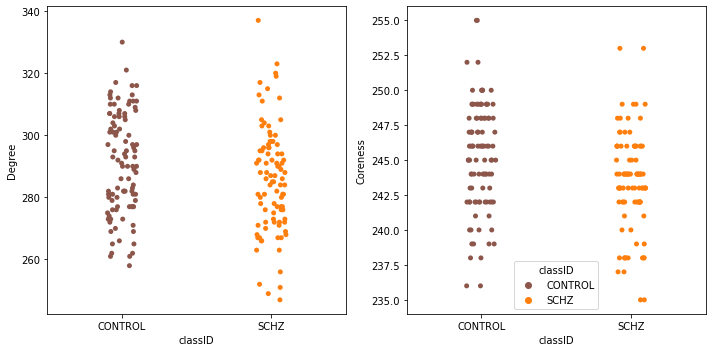

In [19]:
## compute categorical scatter plot for the left and right V1s for gray matter volume and cortical thickness
# create a subplot figure with 1 row and 2 columns
fig, axes = plt.subplots(1,2,figsize=(10,5),sharex=True)

# create a strip plot for each measure
sns.stripplot(x='classID',y='Degree',data=v1,hue='classID',palette=groups_colors,ax=axes[0],size=5,legend=False)
sns.stripplot(x='classID',y='Coreness',data=v1,hue='classID',palette=groups_colors,ax=axes[1],size=5)
fig.tight_layout()

#### behavioral measures

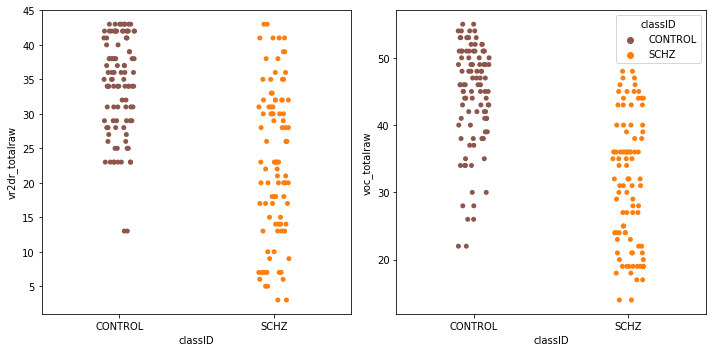

In [18]:
## compute categorical scatter plot for the left and right V1s for gray matter volume and cortical thickness
# create a subplot figure with 1 row and 2 columns
fig, axes = plt.subplots(1,2,figsize=(10,5),sharex=True)

# create a strip plot for each measure
sns.stripplot(x='classID',y='vr2dr_totalraw',data=v1,hue='classID',palette=groups_colors,ax=axes[0],size=5,legend=False)
sns.stripplot(x='classID',y='voc_totalraw',data=v1,hue='classID',palette=groups_colors,ax=axes[1],size=5)
fig.tight_layout()

#### group scatter plots

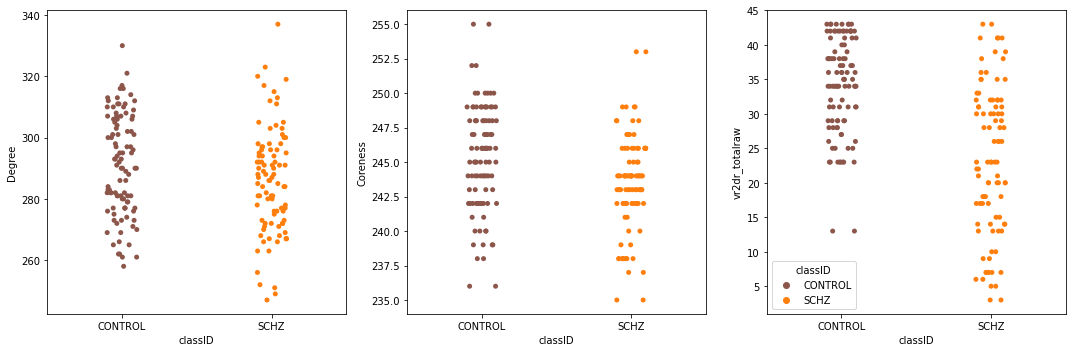

In [17]:
## compute categorical scatter plot for group across behavioral and cortical measures
# create a subplot figure with 1 row and 3 columns
fig, axes = plt.subplots(1,3,figsize=(15,5),sharex=True)

# create a strip plot for each measure
sns.stripplot(x='classID',y='Degree',data=v1,hue='classID',palette=groups_colors,ax=axes[0],size=5,legend=False)
sns.stripplot(x='classID',y='Coreness',data=v1,hue='classID',palette=groups_colors,ax=axes[1],size=5,legend=False)
sns.stripplot(x='classID',y='vr2dr_totalraw',data=v1,hue='classID',palette=groups_colors,ax=axes[2],size=5)
fig.tight_layout()

It looks like there's a difference in the behavioral measures between our groups! Let's investigate a bit more!

<Axes: xlabel='vr2dr_totalraw', ylabel='Count'>

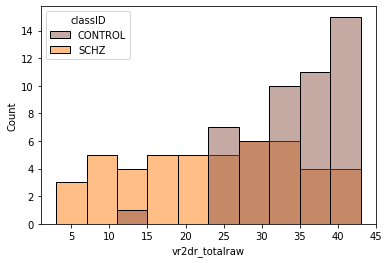

In [20]:
# generate a histogram for each group for the v42dr_totalraw measure
sns.histplot(x='vr2dr_totalraw',hue='classID',data=v1_mean,palette=groups_colors,bins=10)

Let's quantify the differences in our measures of interest. Because we have unequal sample sizes, we can use a bootstrapping procedure and compute ttests from random samples of data from each group. We will be using our pre-defined functions from above, specifically 'bootstrap_analysis_groups' to perform the bootstrapping analysis and 'plot_histogram' to plot the results

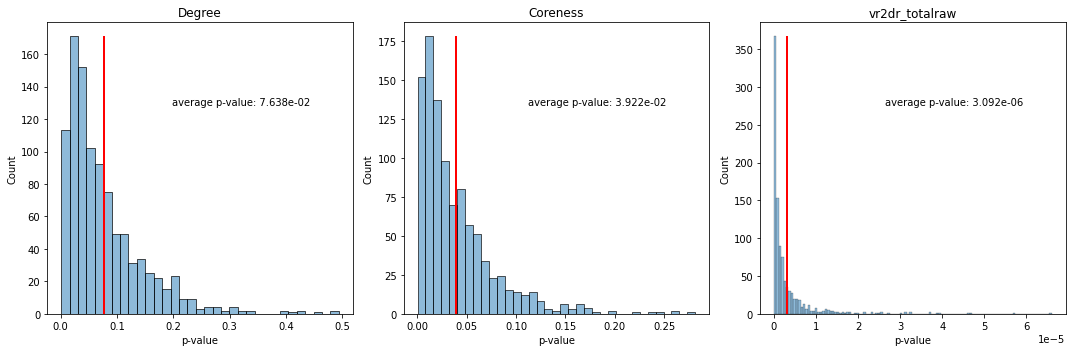

In [21]:
# define our input variables
df = v1_mean
group_1 = 'CONTROL'
group_2 = 'SCHZ'
measures = ['Degree','Coreness','vr2dr_totalraw']
compare_measure = 'ttest'
iterations = 1000

# perform our bootstrapping analysis
hc_schz_correlation = bootstrap_analysis_groups(df,group_1,group_2,measures,sample_size=40,compare_measure=compare_measure,iterations=iterations)

# visualize the results
rows, columns = set_up_figure(measures)
fig, axes = plt.subplots(rows,columns,figsize=(15,5*(rows)),sharex=False)

for i in range(0,len(measures)):        
    row_index = int(np.floor(i / 3))
    col_index = int(i % 3)
    if len(measures) > 3:
        plot_histogram(hc_schz_correlation,measures[i]+'_p-value','p-value',ax=axes[row_index][col_index])
        axes[row_index][col_index].title.set_text(measures[i])
        axes[row_index][col_index].set(xlabel='p-value')
    else:
        plot_histogram(hc_schz_correlation,measures[i]+'_p-value','p-value',ax=axes[col_index])
        axes[col_index].title.set_text(measures[i])
        axes[col_index].set(xlabel='p-value')
fig.tight_layout()

As we can see from the data, it appears there's a statistically significant difference between our groups in the v42dr_totalraw behavioral measures and (barely) with Coreness network measure!

Next, let's see if we can identify any relationships between measures within each group

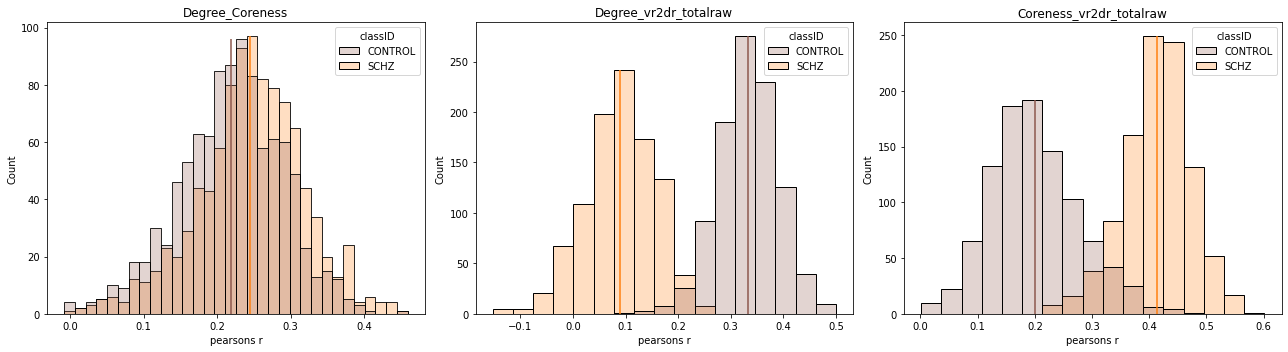

In [22]:
# define our input variables
df = v1_mean
group_1 = 'CONTROL'
group_2 = 'SCHZ'
measures = measures
compare_measure = 'corr'
iterations = 1000

# perform our bootstrapping analysis
within_group_comparison = bootstrap_analysis_within_groups(df,group_1,group_2,measures,sample_size=40,compare_measure=compare_measure,iterations=iterations)
new_measures = [ f for f in within_group_comparison.keys().tolist() if f not in ['classID','iterations'] ]

# visualize the results
rows, columns = set_up_figure(new_measures)
fig, axes = plt.subplots(rows,columns,figsize=(18,5*(rows)),sharex=False)

for i in range(0,len(new_measures)):
    row_index = int(np.floor(i / 3))
    col_index = int(i % 3)
    if len(new_measures) > 3:
        plot_histogram_groups(within_group_comparison,new_measures[i],palette=groups_colors,ax=axes[row_index][col_index])
        axes[row_index][col_index].title.set_text(new_measures[i].replace('_corr',''))
        axes[row_index][col_index].set(xlabel='pearsons r')
    else:
        plot_histogram_groups(within_group_comparison,new_measures[i],palette=groups_colors,ax=axes[col_index])
        axes[col_index].title.set_text(new_measures[i].replace('_corr',''))
        axes[col_index].set(xlabel='pearsons r')        
plt.tight_layout()

<Axes: xlabel='Coreness', ylabel='vr2dr_totalraw'>

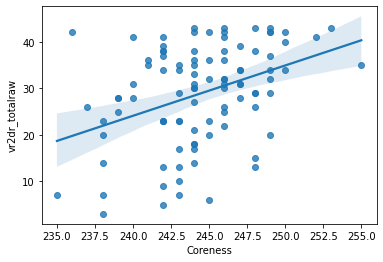

In [23]:
# create a linear regression plot for the overall data between variables of interest
sns.regplot(x='Coreness',y='vr2dr_totalraw',data=v1_mean)

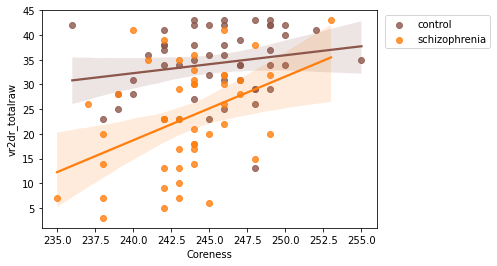

In [24]:
# create a linear regression plot for the each group data between variables of interest
sns.regplot(x='Coreness',y='vr2dr_totalraw',data=v1_mean.loc[v1_mean['classID'] == 'CONTROL'],color=groups_colors['CONTROL'],label='control')
sns.regplot(x='Coreness',y='vr2dr_totalraw',data=v1_mean.loc[v1_mean['classID'] == 'SCHZ'],color=groups_colors['SCHZ'],label='schizophrenia')
plt.legend(bbox_to_anchor=(1.01,1))

## You've now completed your first set of analyses on brainlife.io using the jupyter notebooks!